### Plot Functions [2] Maps 
```
Type: Maps
Projections: NorthPolarStereo
Panels: One / multi
```

*Description*

- This notebook contains the functions to plot the maps in NorthPolarStereo projection using the data/variable provided. 
- The plot will be circular. 
- Has functionality to choose the number of rows and columns for panel plots

The different functions can be used to plot:
- *Contours*
- *Colored Pmesh*
- *Can also be use to make animations (`with a simple loop`) -- examples included* 

In [1]:
import os
import inspect
import xarray as xr
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.lines import Line2D

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter

from datetime import datetime

***Plots ploar maps with circular outlines***

In [2]:
def plot_polar_maps(data_list, options_list, rows=1, cols=1, lat_start=60, lat_end=90, plot_type='contour',
                    common_colorbar=None, cmcbpos=0.2, triend=None, lbl_size=12, clvl=31,
                    fig_title=None, mntpos=None, mntitle_size=None,
                    fsize=(10, 10)):

    """
    Create polar maps with customizable subplots and options.

    Parameters:
    - data_list (list): A list of data arrays to be plotted in each subplot.
    - options_list (list, optional): A list of dictionaries containing options for each subplot. Each dictionary
      may include 'title', 'vmin', 'vmax', 'clrmap', 'lbl', and other subplot-specific settings.
    - rows (int, optional): Number of rows in the subplot grid (default: 1).
    - cols (int, optional): Number of columns in the subplot grid (default: 1).
    - lat_start (int, optional): The starting latitude for the map (default: 60).
    - lat_end (int, optional): The ending latitude for the map (default: 90).
    - plot_type (str, optional): Type of plot ('contour', 'pmesh', or 'imshow') (default: 'contour').
    - common_colorbar (bool, optional): Whether to use a common colorbar for all subplots (default: None).
    - cmcbpos (float, optional): Vertical position of the common colorbar (default: 0.2).
    - triend (str, optional): Colorbar extend option ('neither', 'both', 'min', 'max') (default: None).
    - lbl_size (int, optional): Font size for subplot labels (default: 12).
    - fig_title (str, optional): Main figure title (default: None).
    - mntpos (float, optional): Vertical position of the main figure title (default: None).
    - mntitle_size (int, optional): Font size for the main figure title (default: None).
    - fsize (tuple, optional): Size of the entire figure in inches (default: (10, 10)).

    Returns:
    - fig (matplotlib.figure.Figure): The Matplotlib figure object.
    - axs (list of matplotlib.axes.Axes): A list of Matplotlib axes objects for each subplot.
    """

    
    if plot_type not in ('contour', 'pmesh', 'imshow'):
        raise ValueError("Invalid plot_type. Use 'contour', 'pmesh', or 'imshow'.")

    num_subplots = len(data_list)

    # Ensure data_list and options_list have the same length
    if options_list is not None:
        if len(options_list) != num_subplots:
            raise ValueError("Length of options_list must match the number of subplots.")

    projection = ccrs.NorthPolarStereo()
    fig, axs = plt.subplots(rows, cols, figsize=fsize, subplot_kw={"projection": projection}, constrained_layout=False)

    if rows == 1 and cols == 1:
        axs = [axs]  # Convert to a single-element list for a single plot

    plot_functions = {
        'contour': lambda data, ax, options: ax.contourf(data.lon, data.lat, data, transform=ccrs.PlateCarree(), 
                                                         levels=np.linspace(options['vmin'], options['vmax'], clvl), cmap=options['clrmap']),
        'pmesh': lambda data, ax, options: ax.pcolormesh(data.lon, data.lat, data, transform=ccrs.PlateCarree(), 
                                                         vmin=options['vmin'], vmax=options['vmax'], cmap=options['clrmap']),
    }
        
    for i, (ax, data) in enumerate(zip(axs.flatten(), data_list)):
        if data is not None:
            ax.set_extent([-180, 180, lat_start, lat_end], crs=ccrs.PlateCarree())
            
            theta = np.linspace(0, 2 * np.pi, 100)
            center, radius = [0.5, 0.5], 0.5
            verts = np.vstack([np.sin(theta), np.cos(theta)]).T
            circle = mpl.path.Path(verts * radius + center)
    
            ax.set_boundary(circle, transform=ax.transAxes)
            pcm = plot_functions[plot_type](data, ax, options_list[i])
            ax.title.set_text(options_list[i]['title'])
            ax.coastlines(linewidth=0.25)
            ax.gridlines(draw_labels=False, linewidth=1, color='k', alpha=0.2, linestyle='--', zorder=10)
            # ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
            #       linewidth=0.25, color='k', alpha=0.5, linestyle='--', zorder=10)
    
            options = options_list[i]
            if not common_colorbar:
                cbar = fig.colorbar(pcm, ax=ax, shrink=0.6, pad=0.06, orientation='horizontal', extend=triend)
                cbar.ax.xaxis.set_label_coords(0.5, 1.0 + 1 / 100.0)
                cbar.ax.set_title(options.get('lbl', ''), fontsize=lbl_size)

        else:
            fig.delaxes(ax)  # Remove the subplot if data is None

    if common_colorbar:
        cbar_ax = fig.add_axes([0.15, cmcbpos, 0.7, 0.02])
        fig.colorbar(pcm, cax=cbar_ax, orientation='horizontal', extend=triend)
        cbar_ax.set_title(options_list[0].get('lbl', ''), fontsize=lbl_size)

    
    
    if fig_title:
        plt.suptitle(fig_title, fontsize=mntitle_size, y=mntpos)

    # Use tight_layout to minimize whitespace
    plt.tight_layout()

    return fig, axs

### Testing the fuctions

In [3]:
# run the crop notebook; change to user defined paths 
%run "/work/ab0995/a270229/work/ntbks/py_lumi/crop_data.ipynb" 

source_code = inspect.getsource(xr_subset_nc_file)
print(source_code)

def xr_subset_nc_file(file_path, lon1=None, lon2=None, lat1=None, lat2=None):
    """
    Subset a NetCDF file using xarray indexing and return the result as an xarray Dataset.
    If latlon values are None, the function will open the file without subsetting.

    Parameters:
    - file_path: str, path to the input NetCDF file.
    - lon1: float or None, starting longitude for subsetting.
    - lon2: float or None, ending longitude for subsetting.
    - lat1: float or None, starting latitude for subsetting.
    - lat2: float or None, ending latitude for subsetting.

    Returns:
    - result_ds: xarray.Dataset, the subsetted dataset or the original dataset if latlon values are None.
    
    Example usage:
    - subset_result = subset_nc_file('/work/ab0995/a270229/work/test/tco1279_runs/data/t2.nc', 4, 7, 50, 55)
    - or without subsetting:
    - original_ds = subset_nc_file('/work/ab0995/a270229/work/test/tco1279_runs/data/t2.nc', None, None, None, None)
    """

    # Open the NetCD

In [4]:
# Input file paths
file_uin = '/work/ab0995/a270229/work/test/tco1279_runs/data/u10.nc'
file_vin = '/work/ab0995/a270229/work/test/tco1279_runs/data/v10.nc'

# lon1 = 0   # -180 Starting longitude :None 
# lon2 = 360 #  180 Ending longitude   :None
# lat1 = 60  #  -90 Starting latitude  :None
# lat2 = 90  #   90 Ending latitude    :None

lon1 = None
lon2 = None
lat1 = None
lat2 = None

In [5]:
# Opens the ncfile by subsetting or not

# uf = cdo_subset_nc_file(file_uin, lon1, lon2, lat1, lat2)
# vf = cdo_subset_nc_file(file_vin, lon1, lon2, lat1, lat2)

uf = xr_subset_nc_file(file_uin, lon1, lon2, lat1, lat2)
vf = xr_subset_nc_file(file_vin, lon1, lon2, lat1, lat2)

In [6]:
# # Full resolution
# u = uf.isel(height=0)['10u']
# v = vf.isel(height=0)['10v']

# Don't want all the lat and lon values use this
u = uf.isel(lon=slice(0, -1, 5), lat=slice(1, -1, 5), height=0)['10u']
v = vf.isel(lon=slice(0, -1, 5), lat=slice(1, -1, 5), height=0)['10v']

In [7]:
# Make sample data to plot
mag1 = np.sqrt(u[50]**2 + v[50]**2)
mag2 = np.sqrt(u[245]**2 + v[245]**2)

- ***Example 1***
  * 1 row 2 column
  * with commmon colorbar: 
    + use `common_colorbar=True`; `False` if not 

***Plot Pmesh***

/tmp/ipykernel_375715/3192862255.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


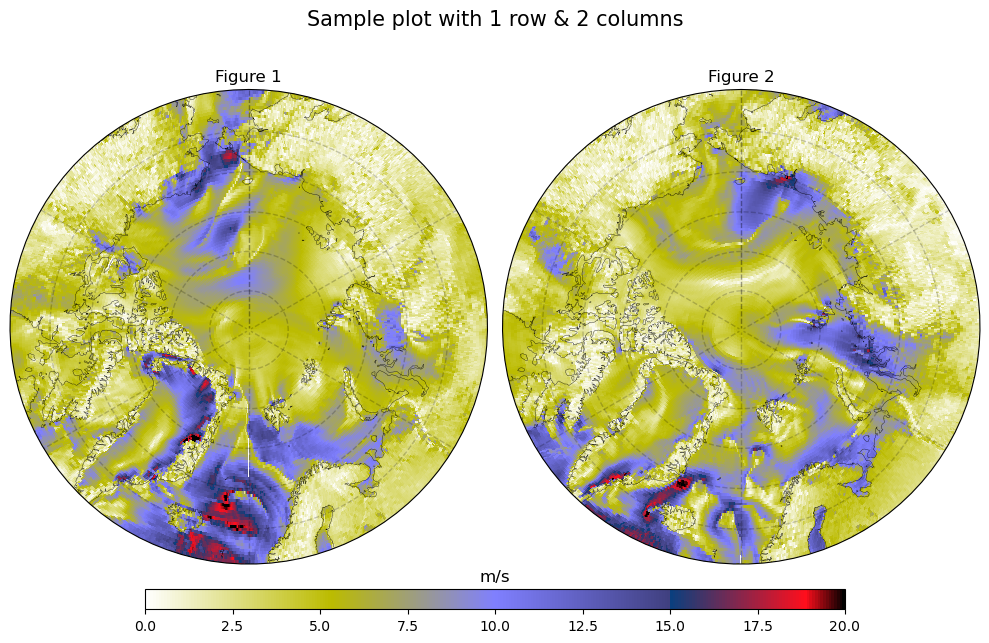

In [8]:
data_list = [mag1, mag2]

# Custom options for each subplot
options_list = [
    {'title': 'Figure 1', 'vmin': 0, 'vmax': 20, 'clrmap': 'gist_stern_r', 'lbl': 'm/s'},
    {'title': 'Figure 2', 'vmin': 0, 'vmax': 20, 'clrmap': 'gist_stern_r', 'lbl': 'm/s'},
   ]

figtitle='Sample plot with 1 row & 2 columns'
fig, axs = plot_polar_maps(data_list, options_list, rows=1, cols=2, 
                           lat_start=60, lat_end=90, plot_type='pmesh', 
                           fig_title=figtitle, mntpos=0.8, mntitle_size=15,
                           common_colorbar=True, fsize=(10, 10))

plt.show()

***Plot Countour***

`use clvl= <your level>`

/tmp/ipykernel_375715/3192862255.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


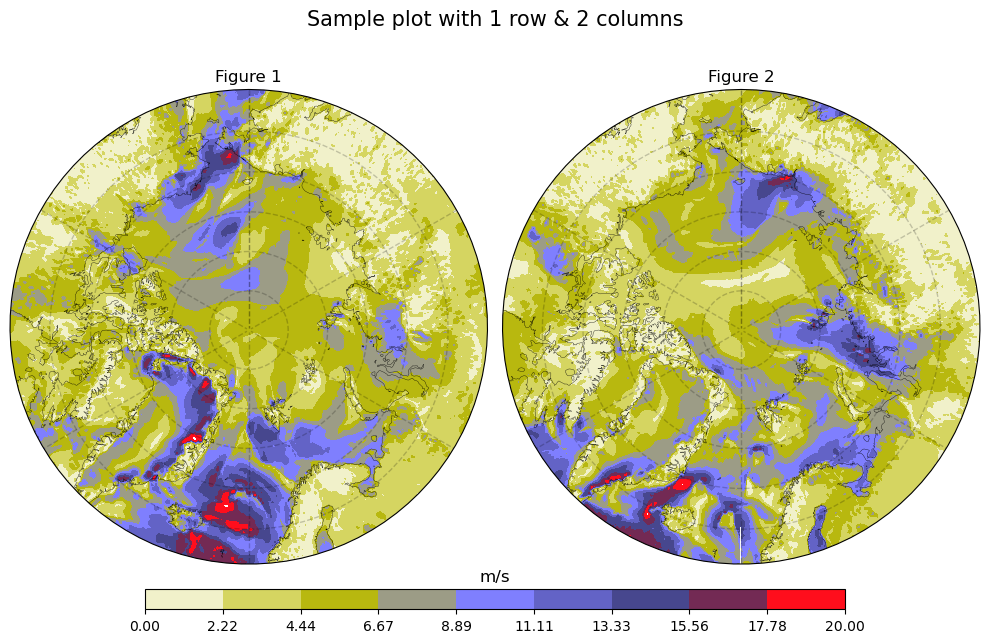

In [9]:
data_list = [mag1, mag2]

# Custom options for each subplot
options_list = [
    {'title': 'Figure 1', 'vmin': 0, 'vmax': 20, 'clrmap': 'gist_stern_r', 'lbl': 'm/s'},
    {'title': 'Figure 2', 'vmin': 0, 'vmax': 20, 'clrmap': 'gist_stern_r', 'lbl': 'm/s'},
   ]

figtitle='Sample plot with 1 row & 2 columns'
fig, axs = plot_polar_maps(data_list, options_list, rows=1, cols=2, 
                           lat_start=60, lat_end=90, plot_type='contour', clvl=10, 
                           fig_title=figtitle, mntpos=0.8, mntitle_size=15,
                           common_colorbar=True, fsize=(10, 10))

plt.show()

- ***Example 2***
  * 2 row 2 column
  * With seperate colorbar:
    + use `common_colorbar=False`

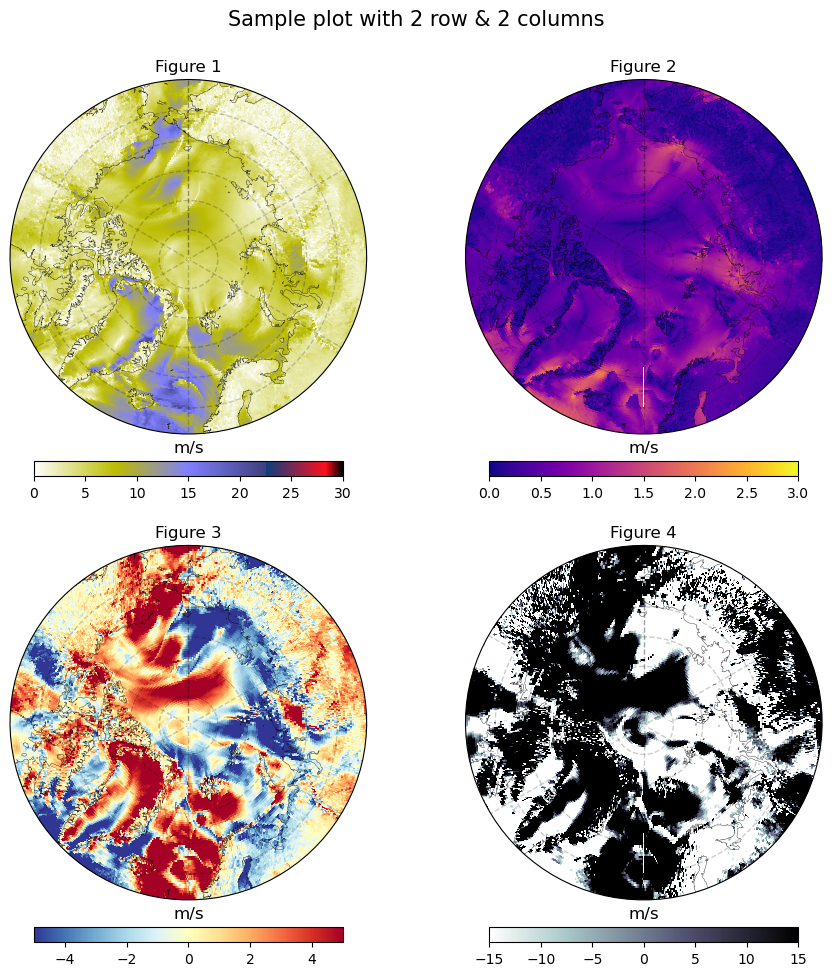

In [10]:
data_list = [mag1, mag2/10, mag1-mag2, ((mag1-mag2)/mag2)*100]

# Custom options for each subplot
options_list = [
    {'title': 'Figure 1', 'vmin': 0, 'vmax': 30, 'clrmap': 'gist_stern_r', 'lbl': 'm/s'},
    {'title': 'Figure 2', 'vmin': 0, 'vmax': 3, 'clrmap': 'plasma', 'lbl': 'm/s'},
    {'title': 'Figure 3', 'vmin': -5, 'vmax': 5, 'clrmap': 'RdYlBu_r', 'lbl': 'm/s'}, 
    {'title': 'Figure 4', 'vmin': -15, 'vmax': 15, 'clrmap': 'bone_r', 'lbl': 'm/s'}]

figtitle='Sample plot with 2 row & 2 columns'
fig, axs = plot_polar_maps(data_list, options_list, rows=2, cols=2, 
                           lat_start=60, lat_end=90, plot_type='pmesh', 
                           fig_title=figtitle, mntpos=1.0, mntitle_size=15,
                           common_colorbar=False, cmcbpos=-0.02, fsize=(10, 10),triend=None)

plt.show()

- ***Example 3***
  * 2 row 2 column
  * With common colorbar: 
    + use `common_colorbar=False`

/tmp/ipykernel_375715/3192862255.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


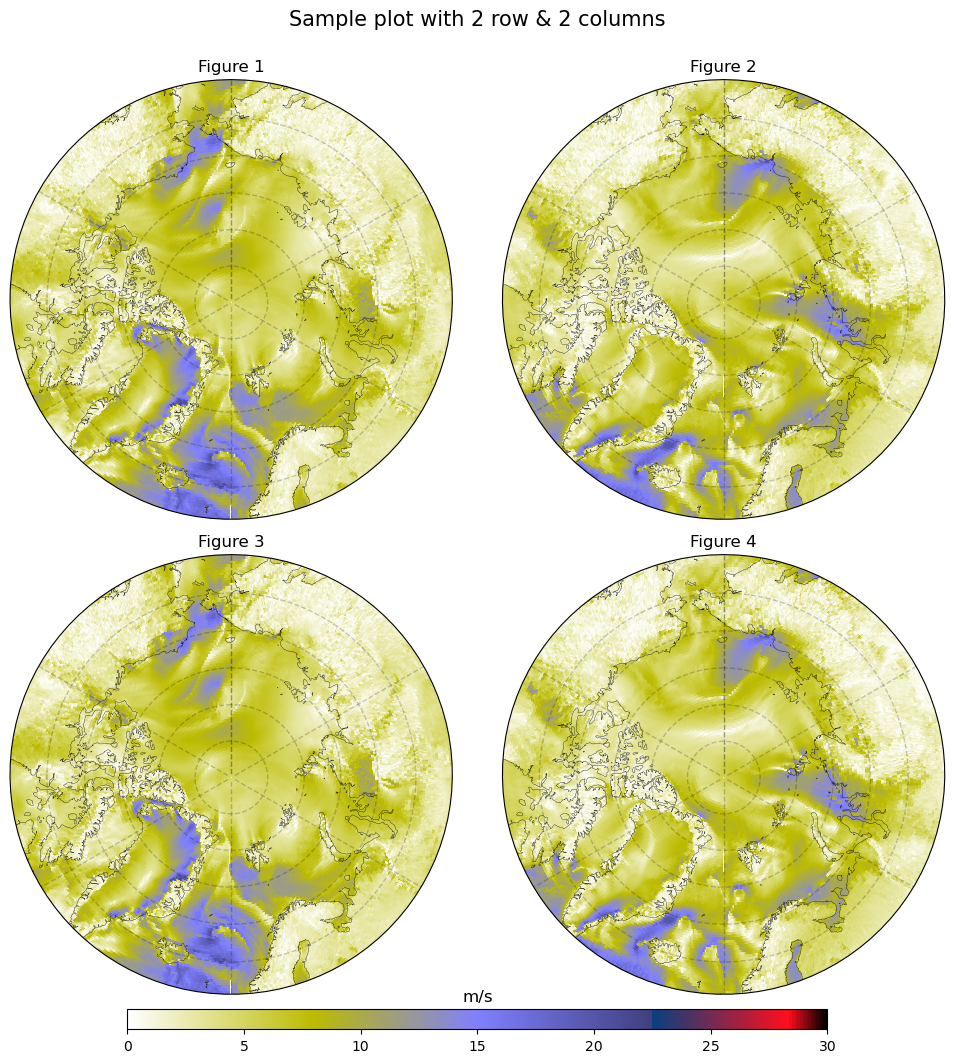

In [11]:
data_list = [mag1, mag2, mag1, mag2]

# Custom options for each subplot
options_list = [
    {'title': 'Figure 1', 'vmin': 0, 'vmax': 30, 'clrmap': 'gist_stern_r', 'lbl': 'm/s'},
    {'title': 'Figure 2', 'vmin': 0, 'vmax': 30, 'clrmap': 'gist_stern_r', 'lbl': 'm/s'},
    {'title': 'Figure 3', 'vmin': 0, 'vmax': 30, 'clrmap': 'gist_stern_r', 'lbl': 'm/s'}, 
    {'title': 'Figure 4', 'vmin': 0, 'vmax': 30, 'clrmap': 'gist_stern_r', 'lbl': 'm/s'}]

figtitle='Sample plot with 2 row & 2 columns'
fig, axs = plot_polar_maps(data_list, options_list, rows=2, cols=2, 
                           lat_start=60, lat_end=90, plot_type='pmesh', 
                           fig_title=figtitle, mntpos=1.0, mntitle_size=15,
                           common_colorbar=True, cmcbpos=-0.02, fsize=(10, 10),triend=None)
plt.show()

- ***Example 4***
  * 2 row 2 column
  * With seperate colorbar: 
    + use `common_colorbar=False`
  * Plots an empty plot when `None` is given

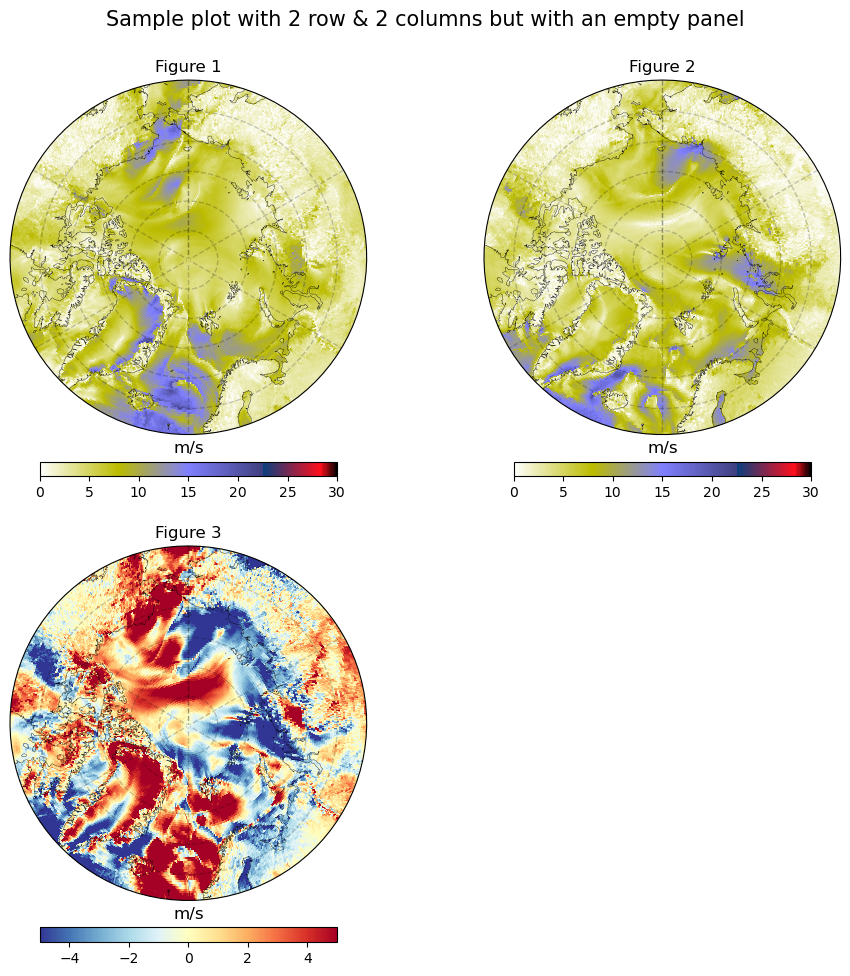

In [12]:
data_list = [mag1, mag2, mag1-mag2, None]

# Custom options for each subplot
options_list = [
    {'title': 'Figure 1', 'vmin': 0, 'vmax': 30, 'clrmap': 'gist_stern_r', 'lbl': 'm/s'},
    {'title': 'Figure 2', 'vmin': 0, 'vmax': 30, 'clrmap': 'gist_stern_r', 'lbl': 'm/s'},
    {'title': 'Figure 3', 'vmin': -5, 'vmax': 5, 'clrmap': 'RdYlBu_r', 'lbl': 'm/s'}, 
    None ]

figtitle='Sample plot with 2 row & 2 columns but with an empty panel'
fig, axs = plot_polar_maps(data_list, options_list, rows=2, cols=2, 
                           lat_start=60, lat_end=90, plot_type='pmesh', 
                           fig_title=figtitle, mntpos=1.0, mntitle_size=15,
                           common_colorbar=False, cmcbpos=-0.02, fsize=(10, 10),triend=None)
plt.show()

**Functionalities to be added in the future**
- The capability to plot common colobars by grouping the plots with same cmap / variable.

***To plot the aninmations***
- use a simple `loop` where the data/magnitude values and the options change. 
- save the plot after each iteration and plot animation by image sequencing